<a href="https://colab.research.google.com/github/bckang-ben/exercise/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
mnist_train = dset.MNIST("../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 256
learning_rate = 0.0002
num_epoch = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



In [4]:
print(len(mnist_train))
print(len(mnist_test))

print(len(mnist_train[0]))
print(mnist_train[0][0].size())

60000
10000
2
torch.Size([1, 28, 28])


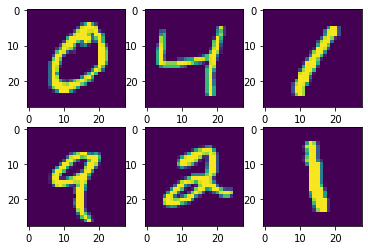

In [3]:
for i in range(1,7):
  plt.subplot(2,3,i)
  # plt.imshow(mnist_train[i][0][0].numpy())
  plt.imshow(mnist_train[i][0].squeeze(0).numpy())
plt.show()

In [5]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),                 #[B, 1, 28, 28] -> [B, 16, 24, 24]
        nn.ReLU(),
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),                #[B, 16, 24, 24] -> [B, 32, 20, 20]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),                                   #[B, 32, 20, 20] -> [B, 32, 10, 10]
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),              #[B, 32, 10, 10] -> [B, 64, 6, 6]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)                                    #[B, 64, 6, 6] -> [B, 64, 3, 3]
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*3*3, 100),
        nn.ReLU(),
        nn.Linear(100,10)
    )
  
  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
loss_arr = []

for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x = image.to(device)
    y_ = label.to(device)

    optimizer.zero_grad()
    pred = model(x)
    loss = loss_func(pred, y_)
    loss.backward()
    optimizer.step()

    if j % 1000 == 0:
      print(loss.item())
      loss_arr.append(loss.cpu().detach().numpy())

2.2993478775024414
0.27496013045310974
0.10841109603643417
0.10323342680931091
0.1107596755027771
0.05175228416919708
0.06371480971574783
0.07622848451137543
0.03301551192998886
0.04931805282831192


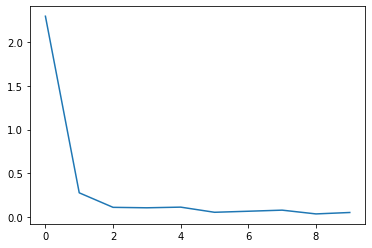

In [10]:
plt.plot(loss_arr)
plt.show()

In [11]:
correct = 0
total = 0

with torch.no_grad():
  for image, label in test_loader:
    x = image.to(device)
    y_ = label.to(device)

    output = model(x)
    _, output_index = torch.max(output, 1)

    total += label.size(0)

    correct += (output_index == y_).sum().float()
  
  print(f'accuracy: {correct/total*100} %')

accuracy: 98.67788696289062 %
